In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm
%matplotlib inline

C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
alldata = pd.read_csv('train.csv', header=0, parse_dates=True, index_col=2)

In [3]:
df = alldata[(alldata['Store']==1) & (alldata['Dept']==1)][['Weekly_Sales']]

In [4]:
df.head()

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


In [5]:
y = df['Weekly_Sales']

In [6]:
type(y)

pandas.core.series.Series

Text(0,0.5,'Weekly Sales')

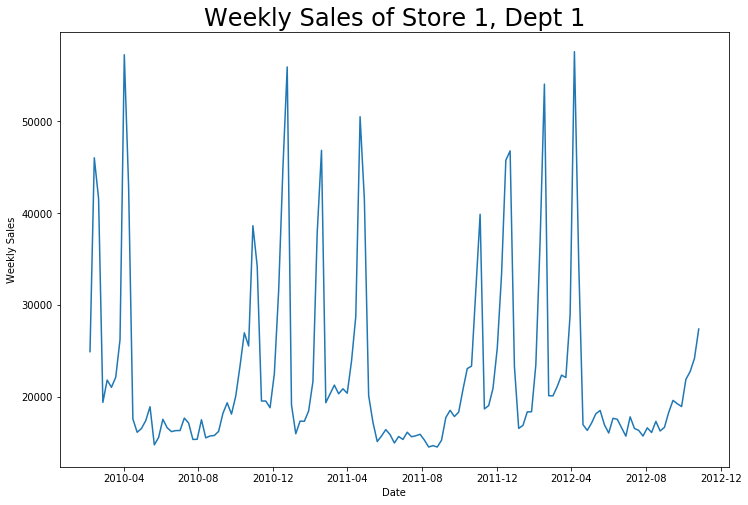

In [7]:
# simple line plot
plt.figure(figsize=(12,8))
plt.plot(df)
plt.title('Weekly Sales of Store 1, Dept 1', fontsize=24)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')

In [8]:
# From this plot, we can see that there is seasonality (large spikes around the same months each year)

### Trend

#### One way to identify a trend pattern is to use moving averages over a specific window of past observations. This smooths the curve by averaging adjacent values over the specified time horizon (rolling window).

In [9]:
def create_features(y):
    df1 = pd.concat((y.rolling(window=4).mean()
                     , y.rolling(window=8).mean()
                     , y.rolling(window=12).mean()
                     , y.rolling(window=52).mean()
                     )
                    ,axis=1) 
    df1.columns = ['Rolling_Mean_4_Weeks','Rolling_Mean_8_Weeks', 'Rolling_Mean_12_Weeks', 'Rolling_Mean_52_Weeks']
    return df1

In [10]:
df_new = pd.concat((df, create_features(y)),axis=1)

In [11]:
#del(df_new)
df_new.head(15)

,Weekly_Sales,Rolling_Mean_4_Weeks,Rolling_Mean_8_Weeks,Rolling_Mean_12_Weeks,Rolling_Mean_52_Weeks
Date,,,,,
2010-02-05,24924.50,NaN,NaN,NaN,NaN
2010-02-12,46039.49,NaN,NaN,NaN,NaN
2010-02-19,41595.55,NaN,NaN,NaN,NaN
2010-02-26,19403.54,32990.7700,NaN,NaN,NaN
2010-03-05,21827.90,32216.6200,NaN,NaN,NaN
2010-03-12,21043.39,25967.5950,NaN,NaN,NaN
2010-03-19,22136.64,21102.8675,NaN,NaN,NaN
2010-03-26,26229.21,22809.2850,27900.02750,NaN,NaN
2010-04-02,57258.43,31666.9175,31941.76875,NaN,NaN


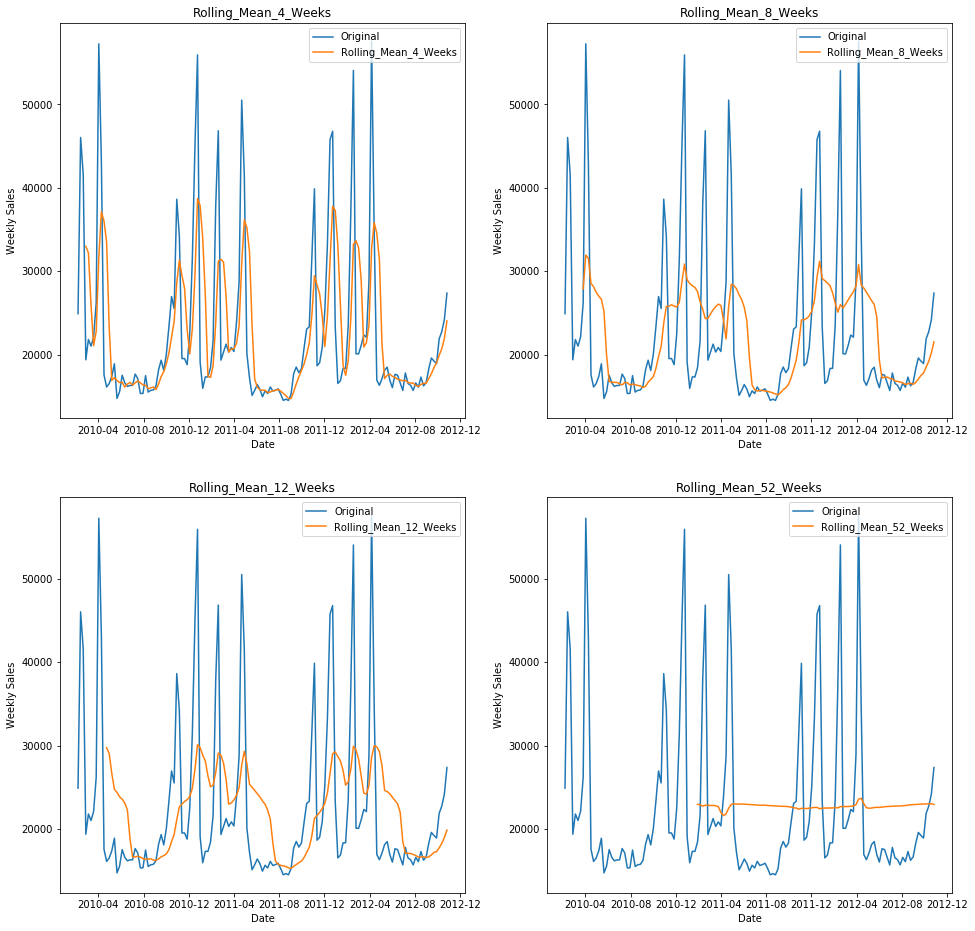

In [12]:
fig, ax = plt.subplots(2,2,figsize=(16,16),sharex=False,sharey=False)
col=1
for r in range(0,2):
    for c in range(0,2):
        ax[r][c].plot(y.index, df_new['Weekly_Sales'], label='Original') 
        ax[r][c].plot(y.index, df_new[df_new.columns[col]], label=df_new.columns[col]) 
        ax[r][c].set_xlabel('Date')
        ax[r][c].set_ylabel('Weekly Sales')
        ax[r][c].set_title(df_new.columns[col])
        ax[r][c].legend(loc='best')
        col += 1           


In [13]:
## We can see that, only when the rolling mean window is increased to 52 weeks, the curve gets smoother. 

### Seasonality

In [14]:
## Seasonality is seen from the plot in ouput 12, we can see the spikes around the same months each year. 

In [15]:
## Seasonal Decomposition graphs 

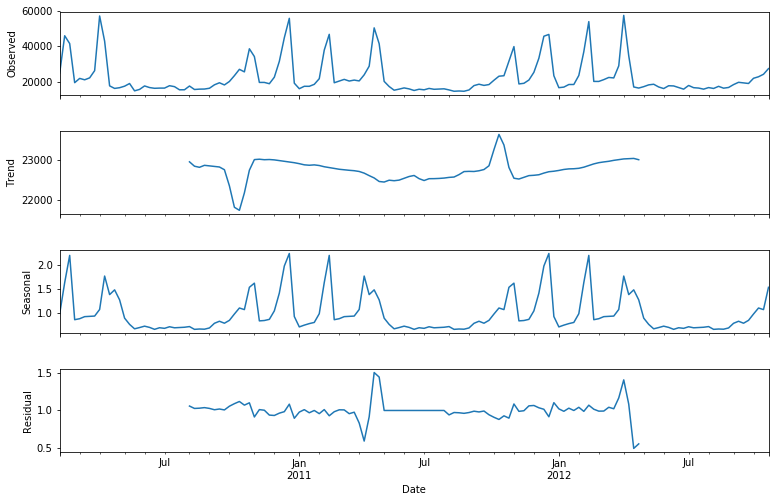

In [16]:
# multiplicative seasonal decomposition

decomp_mul = seasonal_decompose(y, model='multiplicative')
fig = decomp_mul.plot()
fig.set_size_inches(12, 8)

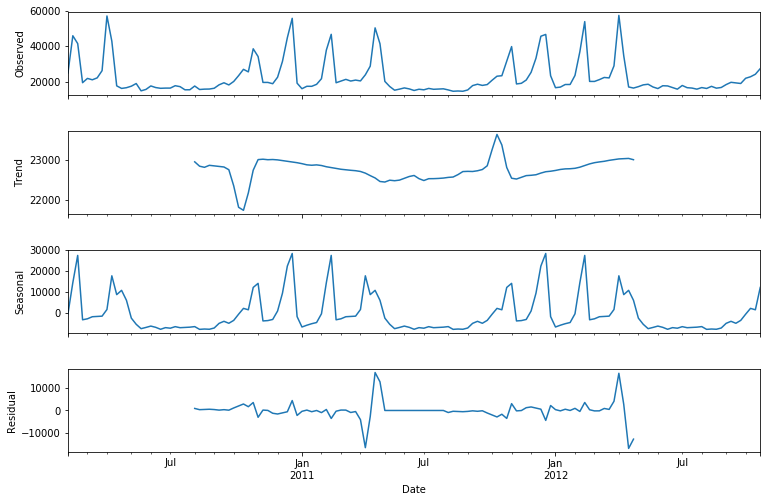

In [17]:
# additive seasonal decomposition

decomp_add = seasonal_decompose(y, model='additive')
fig = decomp_add.plot()
fig.set_size_inches(12, 8)

In [18]:
## Scale is different in additive graphs for Seasonal and residuals.
## Additive decomposition shows high residual values
## So we can say that multiplicative model is preferable.

### Augmented Dickey-Fuller Test for Stationarity

In [19]:
from statsmodels.tsa.stattools import adfuller, kpss

In [20]:
# H0: The time series is non-stationary
# Ha: The time series is stationary

In [21]:
## If the test statistic is smaller than the critical value, the NULL hypothesis is rejected

In [22]:
y = df['Weekly_Sales']

In [23]:
#Perform Dickey-Fuller test:
def adf_test(y):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(y, autolag='AIC')
    print('Test Statistic: ','%f' %(dftest[0]))
    print('p-value: ','%f' %(dftest[1]))
    print('#Lags Used: ','%d' %(dftest[2]))
    print('Number of Observations Used: ','%d' %(dftest[3]))
    print('Critical Values:')
    for key,value in dftest[4].items():            
        print('\t%s: %.3f' %(key, value))


In [24]:
adf_test(y)

Results of Dickey-Fuller Test:
Test Statistic:  -2.522164
p-value:  0.110174
#Lags Used:  6
Number of Observations Used:  136
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


In [25]:
## Because the test statistic is above the 5% critical value and the p-value is larger than 0.05 
## the null hypothesis of the Augmented Dickey-Fuller test cannot be rejected, and it 
## can be said that the series is not stationary.

In [26]:
## Define function with rolling mean and rolling std, ACF, PACF graphs and QQPlot, histogram for normal checking

In [27]:
def ts_diagnostics(y, lags=None, title='', filename=''):
    '''
    Calculate acf, pacf, qq plot and Augmented Dickey Fuller test for a given time series
    '''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    # weekly moving averages 
    rolling_mean = y.rolling(window=26).mean()
    rolling_std = y.rolling(window=26).std()
    
    
    fig = plt.figure(figsize=(14, 12))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    # time series plot
    y.plot(ax=ts_ax,label='Original')
    rolling_mean.plot(ax=ts_ax, color='crimson',label='Rolling Mean');
    rolling_std.plot(ax=ts_ax, color='darkslateblue',label='Rolling Std');
    ts_ax.legend(loc='best')
    ts_ax.set_title(title, fontsize=24);    
    
    # acf and pacf
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 
    
    # qq plot
    sm.qqplot(y, ax=qq_ax)
    qq_ax.set_title('QQ Plot')
    
    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25);
    hist_ax.set_title('Histogram');
    plt.tight_layout();
    plt.savefig('./img/{}.png'.format(filename))
    plt.show()
    
    # perform Augmented Dickey Fuller test
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    print('Test Statistic: ','%f' %(dftest[0]))
    print('p-value: ','%f' %(dftest[1]))
    print('#Lags Used: ','%d' %(dftest[2]))
    print('Number of Observations Used: ','%d' %(dftest[3]))
    print('Critical Values:')
    for key,value in dftest[4].items():            
        print('\t%s: %.3f' %(key, value))    
    return

#### First Difference

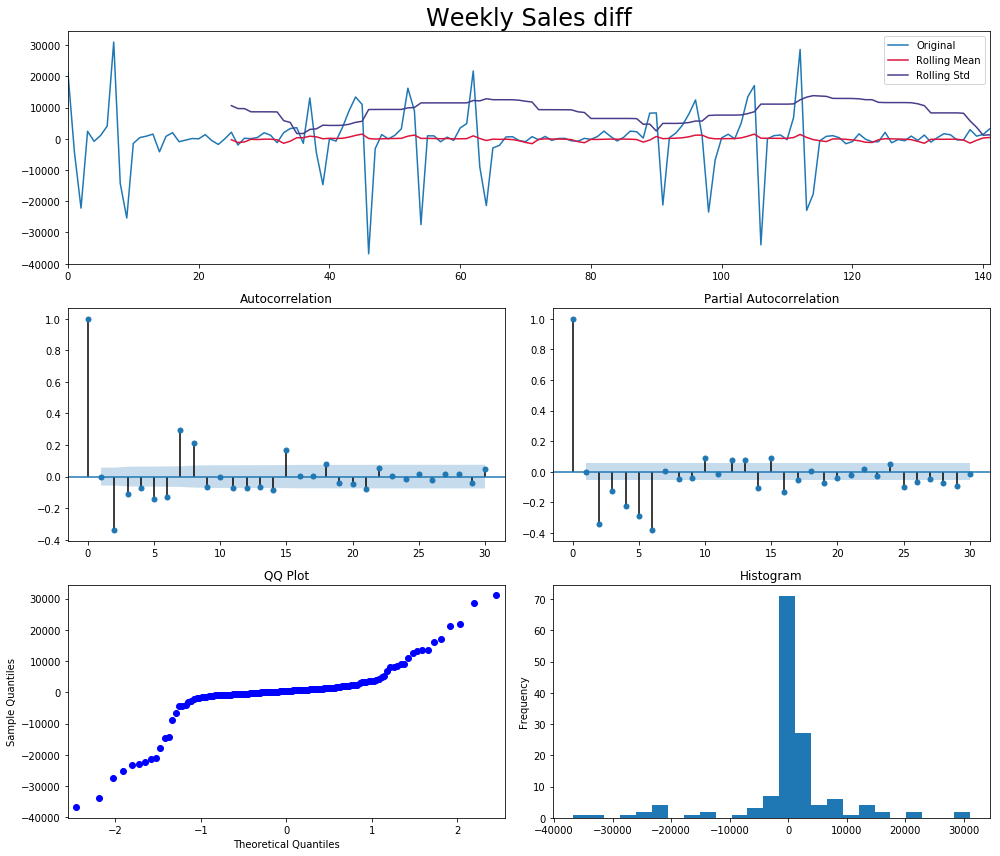

Results of Dickey-Fuller test:
Test Statistic:  -11.044311
p-value:  0.000000
#Lags Used:  5
Number of Observations Used:  136
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


In [28]:
# difference time series
y_diff = np.diff(y)
 
# compute time series diagnostics
ts_diagnostics(y_diff, lags=30, title='Weekly Sales diff', filename='adf_diff')

In [29]:
## 1) The test statistic is less than the critical values, suggesting Null hypothesis can be rejected.
## 2) Looking at the rolling std, we can see that the time series is still not stationary, as the rolling std line is 
## varying over time.
## 3) The rolling mean for the series appears stationary
## 3) Looking at the ACF and PACF graphs, we still can see some spikes, indicating time series not yet stationary.
## 4) QQ plots indicate that the series is not normally distributed
## 5) The histogram is not normally distributed. Most of the data is around center 0

#### Log transform to make the std stationary

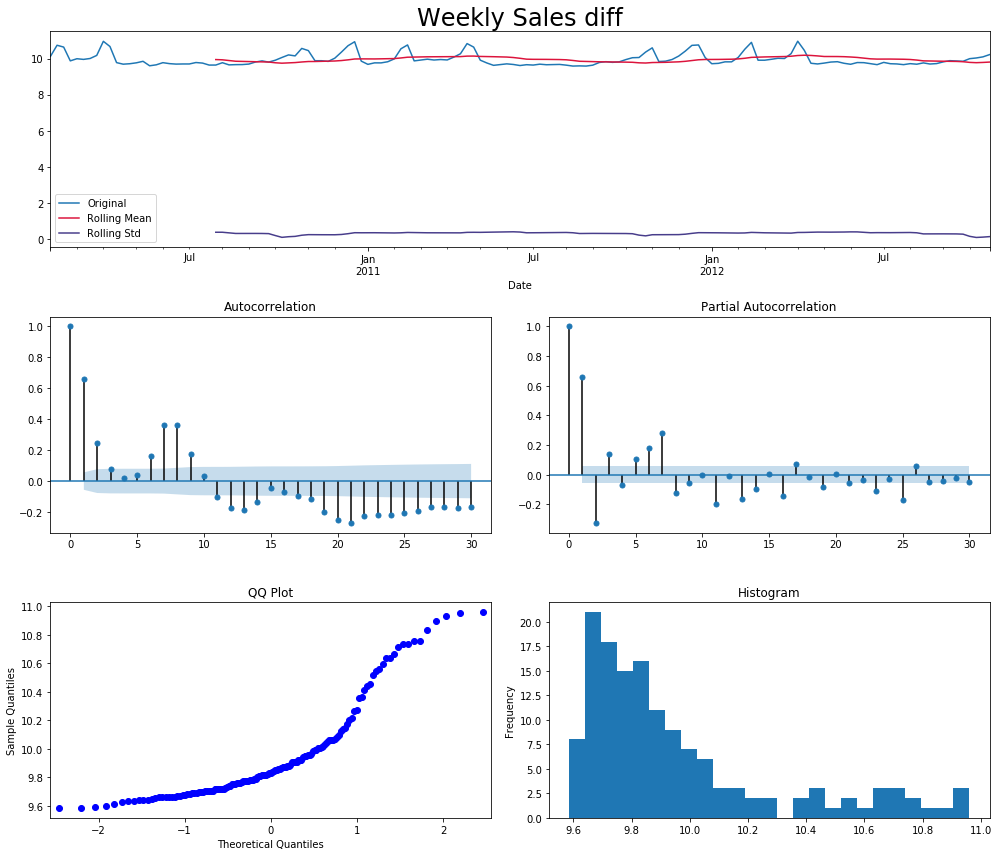

Results of Dickey-Fuller test:
Test Statistic:  -3.061511
p-value:  0.029536
#Lags Used:  10
Number of Observations Used:  132
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579


In [30]:
y_log = np.log(y)

# compute time series diagnostics
ts_diagnostics(y_log, lags=30, title='Weekly Sales diff', filename='adf_log')

In [31]:
## 1) Rolling std has now become stationary, however there are sill spikes in the ACF and PACF graphs
## 2) Histogram indicates series is not normally distributed

#### Log transformed First order difference

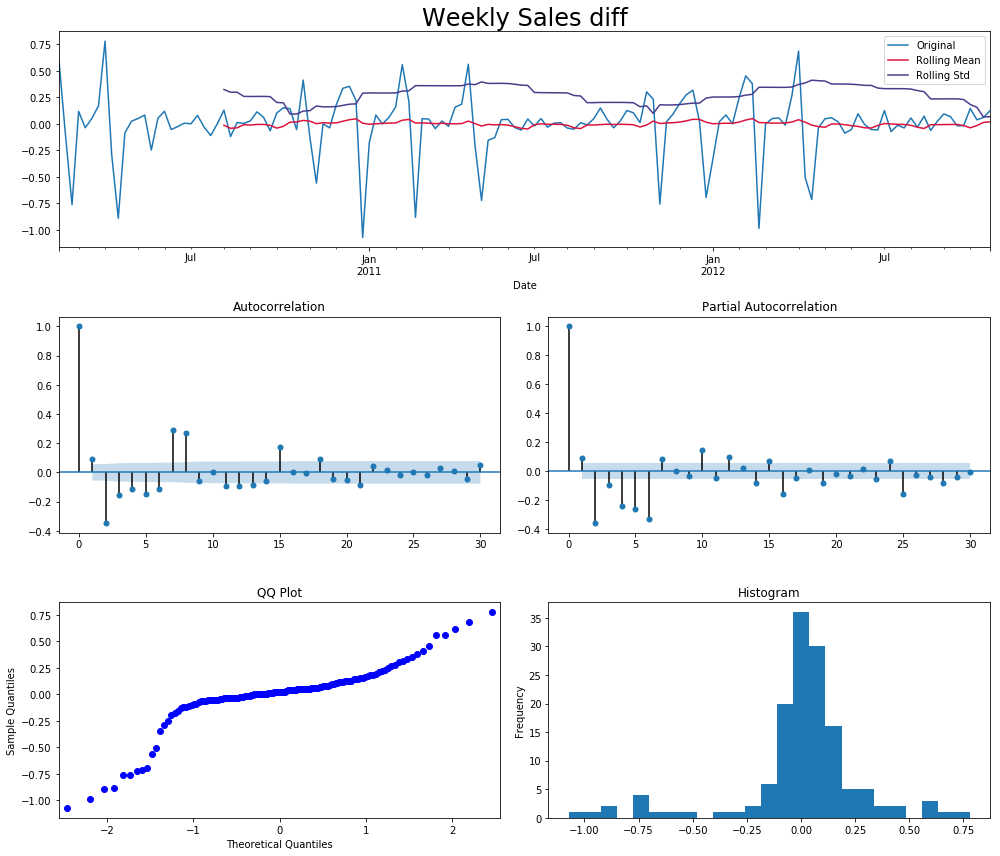

Results of Dickey-Fuller test:
Test Statistic:  -10.204949
p-value:  0.000000
#Lags Used:  5
Number of Observations Used:  136
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


In [32]:
y_log_diff = np.log(y).diff().dropna()

# compute time series diagnostics
ts_diagnostics(y_log_diff, lags=30, title='Weekly Sales diff', filename='adf_log_diff')

In [33]:
## 1) Rolling mean and std has now become stationary, however there are sill spikes in the ACF graph
## 2) Histogram indicates series is normally distributed

#### Log transformed Second Order Differencing

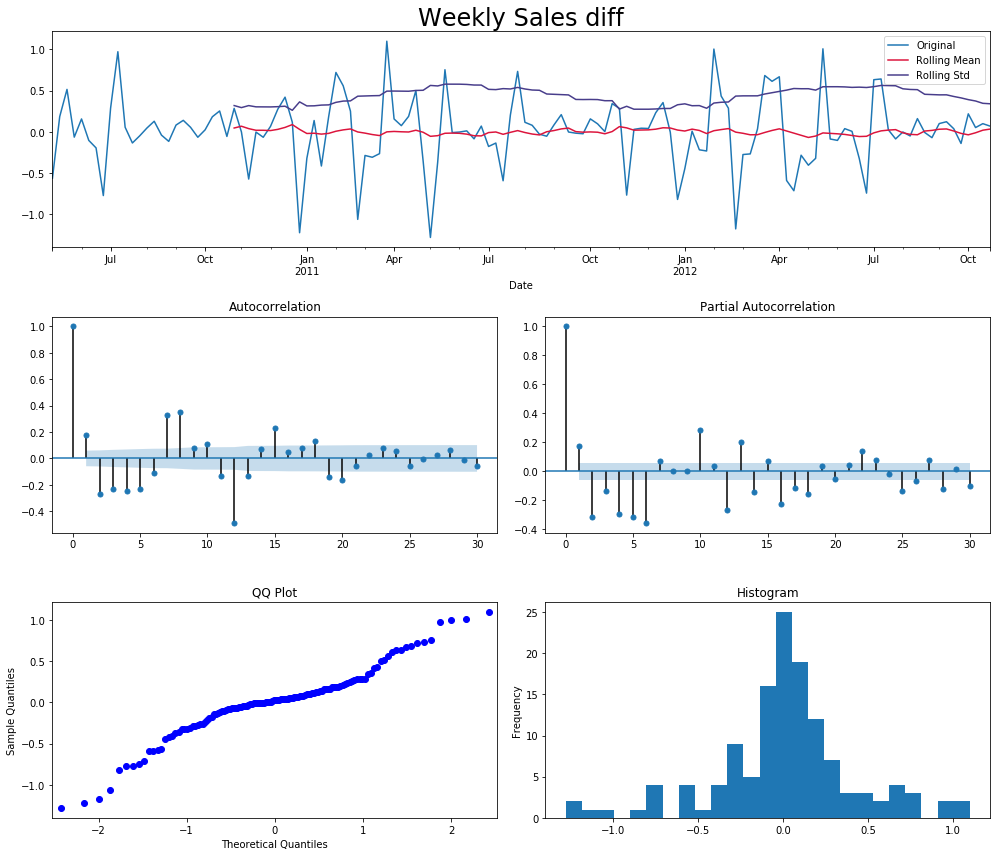

Results of Dickey-Fuller test:
Test Statistic:  -3.127545
p-value:  0.024581
#Lags Used:  13
Number of Observations Used:  116
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


In [34]:
y_log_diff2 = np.log(y).diff().diff(12).dropna()
#y_log_diff2

# compute time series diagnostics
ts_diagnostics(y_log_diff2, lags=30, title='Weekly Sales diff', filename='adf_log_diff2')

In [35]:
## 1) Rolling mean and std around 0
## 2) Histogram is normal
## 3) ACF and PACF still have spikes

### ARIMA

In [36]:
## In the base model there are three parameters (p, d, q) that are used to parameterize ARIMA models

# AutoRegressive component p
# Integration component d
# Moving Average component q

In [37]:
## We fit the ARIMA model to the untransformed data which allows us to extract systematic information from 
## our time series and leave us with white noise residuals.

In [38]:
y = df['Weekly_Sales']

In [39]:
y.head()

Date
2010-02-05    24924.50
2010-02-12    46039.49
2010-02-19    41595.55
2010-02-26    19403.54
2010-03-05    21827.90
Name: Weekly_Sales, dtype: float64

In [40]:
y.tail()

Date
2012-09-28    18947.81
2012-10-05    21904.47
2012-10-12    22764.01
2012-10-19    24185.27
2012-10-26    27390.81
Name: Weekly_Sales, dtype: float64

In [41]:
# Split train and tst sets
y_train = y[:'2011']
y_test = y['2012':]

In [42]:
## We need to find the optimal ARIMA(p, d, q) parameters by looking at the PACF (for p) and ACF (for q). 
## d will be the differencing that was applied

In [43]:
#### Should I consider looking at a SARIMAX model?

#### Model Selection

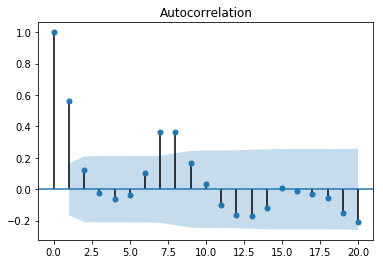

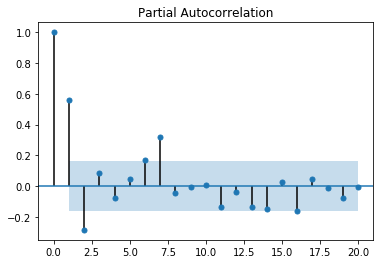

In [44]:
smt.graphics.plot_acf(y, lags=20)
smt.graphics.plot_pacf(y, lags=20); 

#ARIMA(2,0,2)

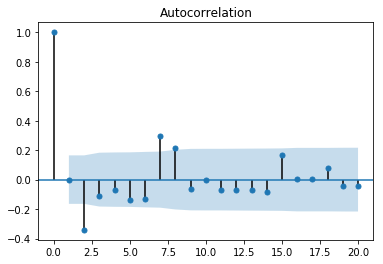

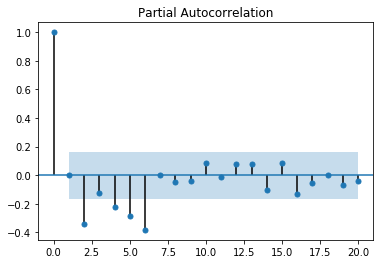

In [45]:
y_diff = np.diff(y)

smt.graphics.plot_acf(y_diff, lags=20)
smt.graphics.plot_pacf(y_diff, lags=20);

#ARIMA(2,1,2)

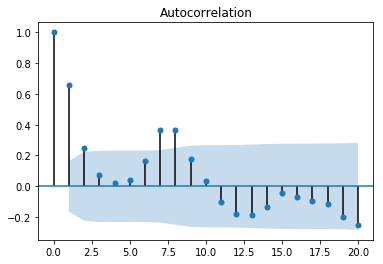

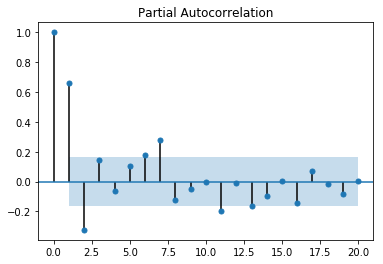

In [46]:
y_log = np.log(y)

smt.graphics.plot_acf(y_log, lags=20)
smt.graphics.plot_pacf(y_log, lags=20);

#ARIMA(2,0,2)

In [47]:
from statsmodels.tsa.arima_model import ARIMA

In [48]:
model_1 = ARIMA(y, order=(2, 0, 2))  
fit_1 = model_1.fit(disp=-1)  
print(fit_1.summary())

                              ARMA Model Results                              
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                     ARMA(2, 2)   Log Likelihood               -1483.378
Method:                       css-mle   S.D. of innovations           7725.216
Date:                Thu, 25 Jan 2018   AIC                           2978.757
Time:                        17:16:01   BIC                           2996.534
Sample:                    02-05-2010   HQIC                          2985.980
                         - 10-26-2012                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                2.25e+04   1210.400     18.588      0.000    2.01e+04    2.49e+04
ar.L1.Weekly_Sales     0.6588      0.560      1.177      0.241      -0.438       1.756
ar.L2.Weekly_Sales  

In [49]:
model_2 = ARIMA(y, order=(2, 1, 0))  
fit_2 = model_2.fit(disp=-1)  
print(fit_2.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Weekly_Sales   No. Observations:                  142
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1488.772
Method:                       css-mle   S.D. of innovations           8642.535
Date:                Thu, 25 Jan 2018   AIC                           2985.545
Time:                        17:16:04   BIC                           2997.368
Sample:                    02-12-2010   HQIC                          2990.349
                         - 10-26-2012                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -19.9019    540.536     -0.037      0.971   -1079.333    1039.529
ar.L1.D.Weekly_Sales     0.0033      0.080      0.042      0.967      -0.154       0.160
ar.L2.D.Week

In [50]:
model_3 = ARIMA(y, order=(0, 1, 2))  
fit_3 = model_3.fit(disp=-1)  
print(fit_3.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Weekly_Sales   No. Observations:                  142
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1477.194
Method:                       css-mle   S.D. of innovations           7847.015
Date:                Thu, 25 Jan 2018   AIC                           2962.389
Time:                        17:16:06   BIC                           2974.212
Sample:                    02-12-2010   HQIC                          2967.193
                         - 10-26-2012                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -17.3913     26.210     -0.664      0.508     -68.761      33.979
ma.L1.D.Weekly_Sales    -0.3374      0.063     -5.351      0.000      -0.461      -0.214
ma.L2.D.Week

In [51]:
model_4 = ARIMA(y, order=(2, 1, 2))  
fit_4 = model_4.fit(disp=-1)  
print(fit_4.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Weekly_Sales   No. Observations:                  142
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1474.632
Method:                       css-mle   S.D. of innovations           7792.708
Date:                Thu, 25 Jan 2018   AIC                           2961.263
Time:                        17:16:08   BIC                           2978.998
Sample:                    02-12-2010   HQIC                          2968.470
                         - 10-26-2012                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -27.9315    228.150     -0.122      0.903    -475.098     419.235
ar.L1.D.Weekly_Sales     1.2052      0.104     11.579      0.000       1.001       1.409
ar.L2.D.Week